# Predicting Heart Disease Likelihood in Cleveland Patients Using Age, Chest Pain, and Cholesterol Levels
### Name: Alice Le

## Introduction
Heart disease is a leading cause of death in the United States, with coronary artery disease being the most prevalent type. This condition often leads to heart attacks as the coronary arteries, which supply oxygen-rich blood to the body, become blocked or narrowed. When these arteries are compromised, the body's overall functioning can be severely affected due to inadequate blood flow (Cleveland Clinic, n.d.).

Several risk factors contribute to the development of heart disease, including high cholesterol levels and aging (WebMD Editorial Contributors, 2023). One of the early warning signs of a heart attack is chest pain, which may indicate that high cholesterol has caused significant artery blockage, reducing blood flow to the heart (Cleveland Clinic, n.d.).

My question is: **Can a new patient's likelihood of having heart disease be predicted based on their age, cholesterol levels, and chest pain?**

The study will utilize the [UCI Heart Disease Dataset from Cleveland](https://archive.ics.uci.edu/dataset/45/heart+disease) for analysis.

## Preliminary exploratory data analysis

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#read data
cleveland <- read_csv("data/heart_disease/processed.cleveland.data",
    col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

#clean and wrangle data
cleveland <- cleveland |> mutate(diag = num > 0, cp_letter = cp < 4, sex = as.factor(as.integer(sex)), fbs = as.factor(as.integer(fbs)), restecg = as.factor(as.integer(restecg)),
                      exang = as.factor(as.integer(exang)), slope = as.factor(as.integer(slope)), thal = as.factor(as.integer(thal)))
head(cleveland)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `thal = as.factor(as.integer(thal))`.
Caused by warning in `is.factor()`:
! NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag,cp_letter
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<fct>,<dbl>,<lgl>,<lgl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6,0,FALSE,TRUE
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3,2,TRUE,FALSE
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7,1,TRUE,FALSE
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3,0,FALSE,TRUE
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3,0,FALSE,TRUE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3,0,FALSE,TRUE


In [3]:
#splitting data into training and testing set
cleveland_split <- initial_split(cleveland, prop = 0.75, strata = diag)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

#summarize training data
head(cleveland_train)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diag,cp_letter
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<fct>,<dbl>,<lgl>,<lgl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6,0,FALSE,TRUE
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3,0,FALSE,TRUE
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3,0,FALSE,TRUE
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3,0,FALSE,TRUE
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3,0,FALSE,FALSE
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6,0,FALSE,FALSE


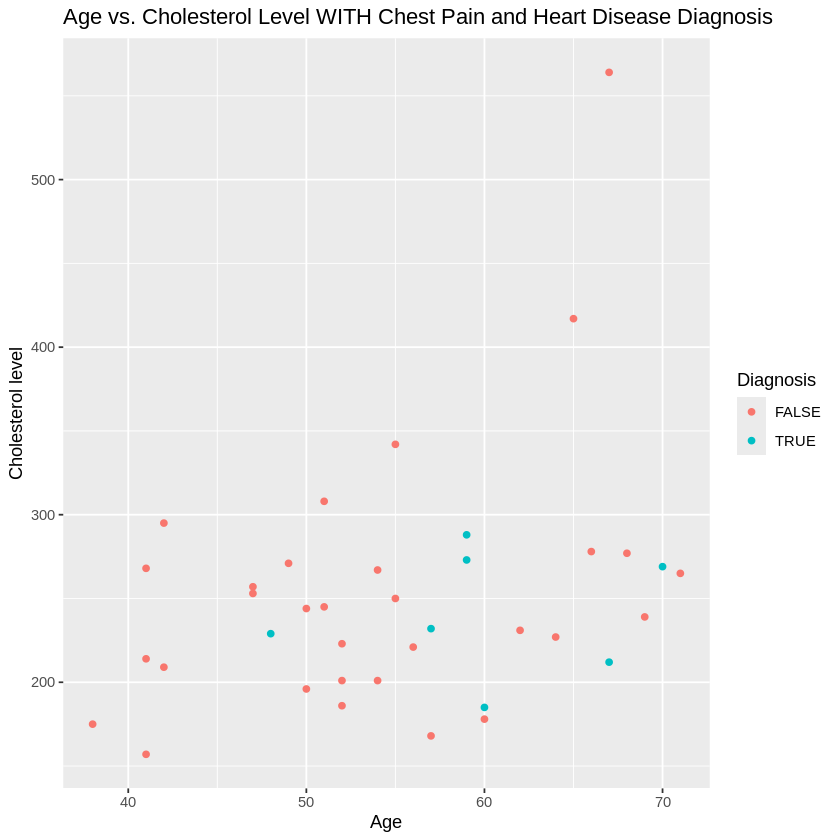

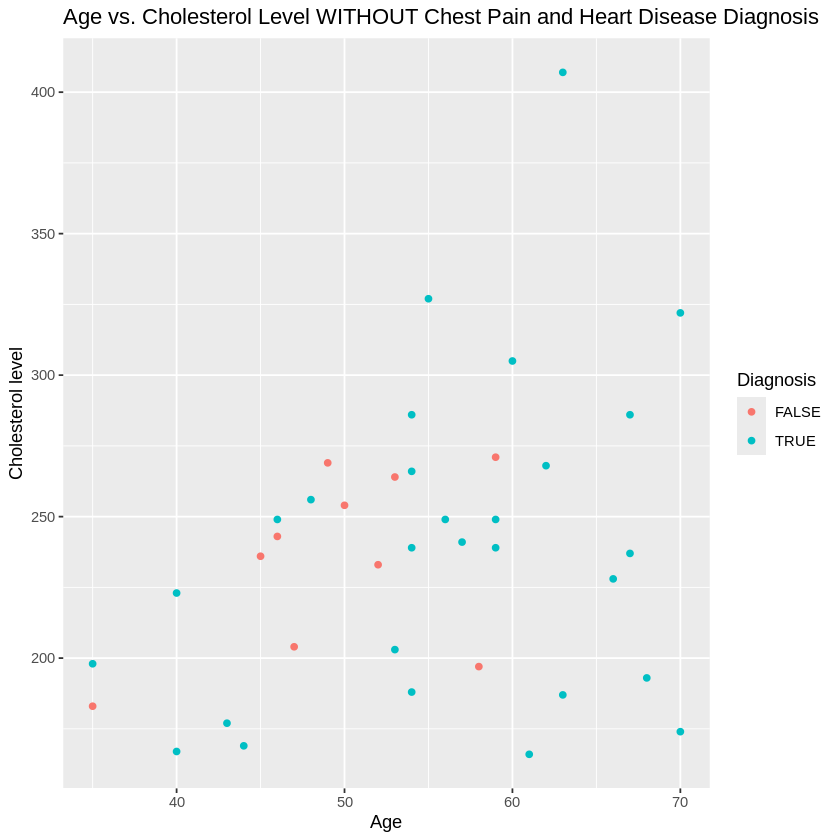

In [4]:
#separate true and false chest pain
cleveland_test_cp_true <- cleveland_test |> filter(cp_letter == TRUE)
cleveland_test_cp_false <- cleveland_test |> filter(cp_letter == FALSE)

#visualize testing data
cp_true_plot <- cleveland_test_cp_true |> ggplot(aes(x = age, y = chol, color = diag)) +
    geom_point() +
    labs(x = "Age", y = "Cholesterol level", color = "Diagnosis") +
    ggtitle("Age vs. Cholesterol Level WITH Chest Pain and Heart Disease Diagnosis")
cp_true_plot

cp_false_plot <- cleveland_test_cp_false |> ggplot(aes(x = age, y = chol, color = diag)) +
    geom_point() +
    labs(x = "Age", y = "Cholesterol level", color = "Diagnosis") +
    ggtitle("Age vs. Cholesterol Level WITHOUT Chest Pain and Heart Disease Diagnosis")
cp_false_plot

## Methods:

The data set being used for this analysis is **processed.cleveland.data** from UCI Heart Disease dataset.

To conduct the data analysis, I will focus on four columns from the dataset: **age**, **cp (chest pain)**, **chol (cholesterol level)**, and **num (diagnosis)**.

To support the analysis, I have derived two additional columns:
- **cp_letter:** This column converts the numerical values of **cp** into boolean values, where values less than 4 are converted to TRUE and values equal to 4 are converted to FALSE.
- **diag:** This column converts the numerical values of **num** into boolean values, where a value of 0 is converted to FALSE (indicating a negative diagnosis) and values greater than 0 are converted to TRUE (indicating a positive diagnosis).

I will split the dataframe into training and testing sets with a ratio of 75% for training and 25% for testing, stratifying **diag** column.

#### Data Summarization
To summarize the training data, I will divide it into two subsets: one for patients with chest pain **(cp_letter = TRUE)** and one for patients without chest pain **(cp_letter = FALSE)**. For each subset, I will calculate summary statistics, including the maximum, minimum, and average values of age and cholesterol level.

#### Data Visualization
I will create two scatter plots to visualize the data:
- <u> Scatter Plot for Patients with Chest Pain </u>: This plot will display cholesterol levels **(chol)** against age **(age)** for patients with chest pain. Observations will be colored based on the **diag** column, indicating whether the diagnosis is TRUE or FALSE.
- <u> Scatter Plot for Patients without Chest Pain </u>: Similarly, this plot will show cholesterol levels **(chol)** against age **(age)** for patients without chest pain, with observations colored by the **diag** column.
These visualizations will help in comparing the relationship between age, cholesterol levels, and the presence or absence of chest pain, along with the diagnosis outcomes.

## Expected outcomes and significance:

#### Expected Findings
Based on the analysis of the selected variables (age, cholesterol levels, and chest pain), I expect to find that higher cholesterol levels may be significantly associated with a greater likelihood of being diagnosed with heart disease. Additionally, older patients are more likely to be diagnosed with heart disease, reflecting the established risk factor of aging. Furthermore, patients experiencing chest pain are more likely to have a positive diagnosis for heart disease compared to those without chest pain.

#### Impact of Findings
The findings from this study could have significant implications in the field of healthcare. By confirming the predictive power of age, cholesterol levels, and chest pain, medical professionals can enhance their risk assessment models for heart disease, leading to earlier diagnosis and more effective intervention strategies. Additionally, identifying high-risk groups based on these factors can help arrange preventive measures and public health policies to better target those most at risk, potentially reducing the overall incidence of heart disease. Moreover, educating patients about these key risk factors can empower them to take proactive steps in managing their health, such as monitoring cholesterol levels and seeking medical advice promptly when experiencing chest pain.

#### Future Questions
1. Can we improve predictions by including lifestyle factors like diet and exercise?
2. What other early warning signs, besides chest pain, could indicate a risk of heart disease?

## Bibliography
Cleveland Clinic medical professional. “Heart Disease.” *Cleveland Clinic*, https://my.clevelandclinic.org/health/diseases/24129-heart-disease. Accessed 8 June 2024. 

Cleveland Clinic medical professional. “Coronary Artery Disease.” *Cleveland Clinic*, https://my.clevelandclinic.org/health/diseases/16898-coronary-artery-disease. Accessed 8 June 2024. 

WebMD Editorial Contributors. “Risk Factors for Heart Disease.” *WebMD*, 2023, www.webmd.com/heart-disease/risk-factors-for-heart-disease. Accessed 8 June 2024. 